In [1]:
import os
for dirname, _, filenames in os.walk('../Data/base'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

../Data/base\sample_submission.csv
../Data/base\test_identity.csv
../Data/base\test_transaction.csv
../Data/base\train_identity.csv
../Data/base\train_transaction.csv


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
from numba import jit
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import gc
import os
import psutil
process = psutil.Process(os.getpid())

pd.set_option('display.max_columns', 500)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
files = []


for dirname, _, filenames in os.walk('../Data/base'):
    for filename in filenames:
        files.append(os.path.join(dirname, filename))
        

import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns
import matplotlib.pylab as plt

import lightgbm as lgb
import xgboost as xgb

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold, GroupKFold, GridSearchCV, train_test_split, TimeSeriesSplit
from sklearn import metrics
# Any results you write to the current directory are saved as output.

import altair as alt
from altair.vega import v5
from IPython.display import HTML

import time

from tqdm import tqdm_notebook

RANDOM_SEED = 42

files

['../Data/base\\sample_submission.csv',
 '../Data/base\\test_identity.csv',
 '../Data/base\\test_transaction.csv',
 '../Data/base\\train_identity.csv',
 '../Data/base\\train_transaction.csv']

In [3]:
# using ideas from this kernel: https://www.kaggle.com/notslush/altair-visualization-2018-stackoverflow-survey
def prepare_altair():
    """
    Helper function to prepare altair for working.
    """

    vega_url = 'https://cdn.jsdelivr.net/npm/vega@' + v5.SCHEMA_VERSION
    vega_lib_url = 'https://cdn.jsdelivr.net/npm/vega-lib'
    vega_lite_url = 'https://cdn.jsdelivr.net/npm/vega-lite@' + alt.SCHEMA_VERSION
    vega_embed_url = 'https://cdn.jsdelivr.net/npm/vega-embed@3'
    noext = "?noext"
    
    paths = {
        'vega': vega_url + noext,
        'vega-lib': vega_lib_url + noext,
        'vega-lite': vega_lite_url + noext,
        'vega-embed': vega_embed_url + noext
    }
    
    workaround = f"""    requirejs.config({{
        baseUrl: 'https://cdn.jsdelivr.net/npm/',
        paths: {paths}
    }});
    """
    
    return workaround
    

def add_autoincrement(render_func):
    # Keep track of unique <div/> IDs
    cache = {}
    def wrapped(chart, id="vega-chart", autoincrement=True):
        if autoincrement:
            if id in cache:
                counter = 1 + cache[id]
                cache[id] = counter
            else:
                cache[id] = 0
            actual_id = id if cache[id] == 0 else id + '-' + str(cache[id])
        else:
            if id not in cache:
                cache[id] = 0
            actual_id = id
        return render_func(chart, id=actual_id)
    # Cache will stay outside and 
    return wrapped
           

@add_autoincrement
def render(chart, id="vega-chart"):
    """
    Helper function to plot altair visualizations.
    """
    chart_str = """
    <div id="{id}"></div><script>
    require(["vega-embed"], function(vg_embed) {{
        const spec = {chart};     
        vg_embed("#{id}", spec, {{defaultStyle: true}}).catch(console.warn);
        console.log("anything?");
    }});
    console.log("really...anything?");
    </script>
    """
    return HTML(
        chart_str.format(
            id=id,
            chart=json.dumps(chart) if isinstance(chart, dict) else chart.to_json(indent=None)
        )
    )
    

def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage(deep=True).sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                c_prec = df[col].apply(lambda x: np.finfo(x).precision).max()
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max and c_prec == np.finfo(np.float32).precision:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage(deep=True).sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df
    

@jit
def fast_auc(y_true, y_prob):
    """
    fast roc_auc computation: https://www.kaggle.com/c/microsoft-malware-prediction/discussion/76013
    """
    y_true = np.asarray(y_true)
    y_true = y_true[np.argsort(y_prob)]
    nfalse = 0
    auc = 0
    n = len(y_true)
    for i in range(n):
        y_i = y_true[i]
        nfalse += (1 - y_i)
        auc += y_i * nfalse
    auc /= (nfalse * (n - nfalse))
    return auc


def eval_auc(y_true, y_pred):
    """
    Fast auc eval function for lgb.
    """
    return 'auc', fast_auc(y_true, y_pred), True


def group_mean_log_mae(y_true, y_pred, types, floor=1e-9):
    """
    Fast metric computation for this competition: https://www.kaggle.com/c/champs-scalar-coupling
    Code is from this kernel: https://www.kaggle.com/uberkinder/efficient-metric
    """
    maes = (y_true-y_pred).abs().groupby(types).mean()
    return np.log(maes.map(lambda x: max(x, floor))).mean()
    


def train_model_classification(X, X_test, y, params, folds, model_type='lgb', eval_metric='auc', columns=None, plot_feature_importance=False, model=None,
                               verbose=10000, early_stopping_rounds=200, n_estimators=50000, splits=None, n_folds=3, averaging='usual', n_jobs=-1):
    """
    A function to train a variety of classification models.
    Returns dictionary with oof predictions, test predictions, scores and, if necessary, feature importances.
    
    :params: X - training data, can be pd.DataFrame or np.ndarray (after normalizing)
    :params: X_test - test data, can be pd.DataFrame or np.ndarray (after normalizing)
    :params: y - target
    :params: folds - folds to split data
    :params: model_type - type of model to use
    :params: eval_metric - metric to use
    :params: columns - columns to use. If None - use all columns
    :params: plot_feature_importance - whether to plot feature importance of LGB
    :params: model - sklearn model, works only for "sklearn" model type
    
    """
    columns = X.columns if columns is None else columns
    n_splits = folds.n_splits if splits is None else n_folds
    X_test = X_test[columns]
    
    # to set up scoring parameters
    metrics_dict = {'auc': {'lgb_metric_name': eval_auc,
                        'catboost_metric_name': 'AUC',
                        'sklearn_scoring_function': metrics.roc_auc_score},
                    }
    
    result_dict = {}
    if averaging == 'usual':
        # out-of-fold predictions on train data
        oof = np.zeros((len(X), 1))

        # averaged predictions on train data
        prediction = np.zeros((len(X_test), 1))
        
    elif averaging == 'rank':
        # out-of-fold predictions on train data
        oof = np.zeros((len(X), 1))

        # averaged predictions on train data
        prediction = np.zeros((len(X_test), 1))

    
    # list of scores on folds
    scores = []
    feature_importance = pd.DataFrame()
    
    # split and train on folds
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        print(f'Fold {fold_n + 1} started at {time.ctime()}')
        if type(X) == np.ndarray:
            X_train, X_valid = X[columns][train_index], X[columns][valid_index]
            y_train, y_valid = y[train_index], y[valid_index]
        else:
            X_train, X_valid = X[columns].iloc[train_index], X[columns].iloc[valid_index]
            y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
            
        if model_type == 'lgb':
            model = lgb.LGBMClassifier(**params, n_estimators=n_estimators, n_jobs = n_jobs)
            model.fit(X_train, y_train, 
                    eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric=metrics_dict[eval_metric]['lgb_metric_name'],
                    verbose=verbose, early_stopping_rounds=early_stopping_rounds)
            
            y_pred_valid = model.predict_proba(X_valid)[:, 1]
            y_pred = model.predict_proba(X_test, num_iteration=model.best_iteration_)[:, 1]
            
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train, feature_names=X.columns)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid, feature_names=X.columns)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=n_estimators, evals=watchlist, early_stopping_rounds=early_stopping_rounds, verbose_eval=verbose, params=params)
            y_pred_valid = model.predict(xgb.DMatrix(X_valid, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
            y_pred = model.predict(xgb.DMatrix(X_test, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
        
        if model_type == 'sklearn':
            model = model
            model.fit(X_train, y_train)
            
            y_pred_valid = model.predict(X_valid).reshape(-1,)
            score = metrics_dict[eval_metric]['sklearn_scoring_function'](y_valid, y_pred_valid)
            print(f'Fold {fold_n}. {eval_metric}: {score:.4f}.')
            print('')
            
            y_pred = model.predict_proba(X_test)
        
        if model_type == 'cat':
            model = CatBoostClassifier(iterations=n_estimators, eval_metric=metrics_dict[eval_metric]['catboost_metric_name'], **params,
                                      loss_function=Logloss)
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True, verbose=False)

            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test)
        
        if averaging == 'usual':
            
            oof[valid_index] = y_pred_valid.reshape(-1, 1)
            scores.append(metrics_dict[eval_metric]['sklearn_scoring_function'](y_valid, y_pred_valid))
            
            prediction += y_pred.reshape(-1, 1)

        elif averaging == 'rank':
                                  
            oof[valid_index] = y_pred_valid.reshape(-1, 1)
            scores.append(metrics_dict[eval_metric]['sklearn_scoring_function'](y_valid, y_pred_valid))
                                  
            prediction += pd.Series(y_pred).rank().values.reshape(-1, 1)        
        
        if model_type == 'lgb' and plot_feature_importance:
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= n_splits
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    result_dict['oof'] = oof
    result_dict['prediction'] = prediction
    result_dict['scores'] = scores
    result_dict['model'] = model
    
    if model_type == 'lgb':
        if plot_feature_importance:
            feature_importance["importance"] /= n_splits
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
                    
            result_dict['feature_importance'] = feature_importance
            result_dict['top_columns'] = cols
        
    return result_dict

# setting up altair
workaround = prepare_altair()
HTML("".join((
    "<script>",
    workaround,
    "</script>",
)))

## Load files

In [5]:
folder_path = '../Data/base/'
train_id = pd.read_csv(f'{folder_path}train_identity.csv')
train_tr = pd.read_csv(f'{folder_path}train_transaction.csv')

test_id = pd.read_csv(f'{folder_path}test_identity.csv')
test_tr = pd.read_csv(f'{folder_path}test_transaction.csv')

sample_submission = pd.read_csv(f'{folder_path}sample_submission.csv')


MemoryError: 

## Explore the data

In [ ]:
print('train_tr shape is {}'.format(train_tr.shape))
print('test_tr shape is {}'.format(test_tr.shape))
print('train_id shape is {}'.format(train_id.shape))
print('test_id shape is {}'.format(test_id.shape))

In [ ]:
train_id.info(null_counts=True)

In [7]:
train_tr.info()
train_tr[train_tr.columns[:40]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Columns: 394 entries, TransactionID to V339
dtypes: float64(376), int64(4), object(14)
memory usage: 1.7+ GB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Data columns (total 40 columns):
TransactionID     590540 non-null int64
isFraud           590540 non-null int64
TransactionDT     590540 non-null int64
TransactionAmt    590540 non-null float64
ProductCD         590540 non-null object
card1             590540 non-null int64
card2             581607 non-null float64
card3             588975 non-null float64
card4             588963 non-null object
card5             586281 non-null float64
card6             588969 non-null object
addr1             524834 non-null float64
addr2             524834 non-null float64
dist1             238269 non-null float64
dist2             37627 non-null float64
P_emaildomain     496084 non-null object
R_emaildomain     137291 non-null object
C1

In [8]:
test_tr[test_tr.columns].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506691 entries, 0 to 506690
Columns: 393 entries, TransactionID to V339
dtypes: float64(376), int64(3), object(14)
memory usage: 1.5+ GB


In [9]:
test_id[test_id.columns].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141907 entries, 0 to 141906
Data columns (total 41 columns):
TransactionID    141907 non-null int64
id_01            141907 non-null float64
id_02            136976 non-null float64
id_03            66481 non-null float64
id_04            66481 non-null float64
id_05            134750 non-null float64
id_06            134750 non-null float64
id_07            5059 non-null float64
id_08            5059 non-null float64
id_09            74338 non-null float64
id_10            74338 non-null float64
id_11            136778 non-null float64
id_12            141907 non-null object
id_13            130286 non-null float64
id_14            71357 non-null float64
id_15            136977 non-null object
id_16            125747 non-null object
id_17            135966 non-null float64
id_18            50875 non-null float64
id_19            135906 non-null float64
id_20            135633 non-null float64
id_21            5059 non-null float64
id_2

### Merge

In [10]:
# Merge the datasets
train = pd.merge(train_tr, train_id, on='TransactionID', how='left')
test = pd.merge(test_tr, test_id, on='TransactionID', how='left')

del train_tr, train_id, test_tr, test_id
gc.collect()

0

## Plot
We can see that the data is split up based on the time delta

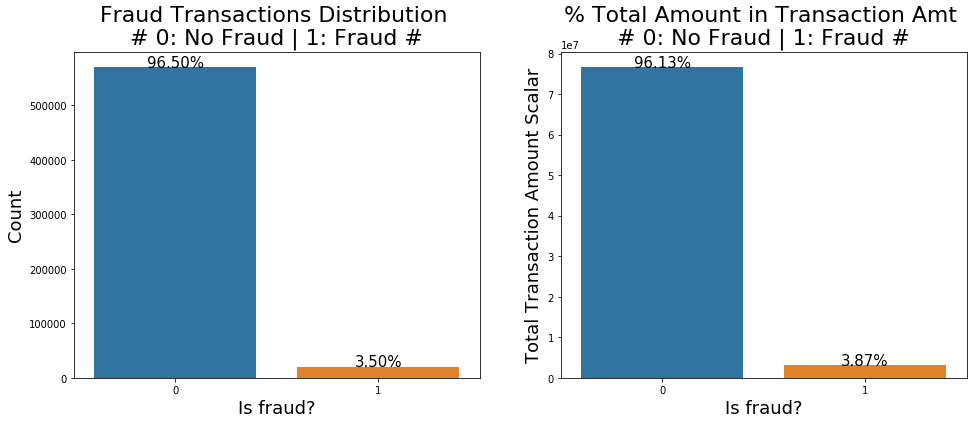

In [11]:
# https://www.kaggle.com/kabure/extensive-eda-and-modeling-xgb-hyperopt
train['TransactionAmt'] = train['TransactionAmt'].astype(float)
total = len(train)
total_amt = train.groupby(['isFraud'])['TransactionAmt'].sum().sum()
plt.figure(figsize=(16,6))

plt.subplot(121)
g = sns.countplot(x='isFraud', data=train, )
g.set_title("Fraud Transactions Distribution \n# 0: No Fraud | 1: Fraud #", fontsize=22)
g.set_xlabel("Is fraud?", fontsize=18)
g.set_ylabel('Count', fontsize=18)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=15) 

perc_amt = (train.groupby(['isFraud'])['TransactionAmt'].sum())
perc_amt = perc_amt.reset_index()
plt.subplot(122)
g1 = sns.barplot(x='isFraud', y='TransactionAmt',  dodge=True, data=perc_amt)
g1.set_title("% Total Amount in Transaction Amt \n# 0: No Fraud | 1: Fraud #", fontsize=22)
g1.set_xlabel("Is fraud?", fontsize=18)
g1.set_ylabel('Total Transaction Amount Scalar', fontsize=18)
for p in g1.patches:
    height = p.get_height()
    g1.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total_amt * 100),
            ha="center", fontsize=15) 
    
plt.show()

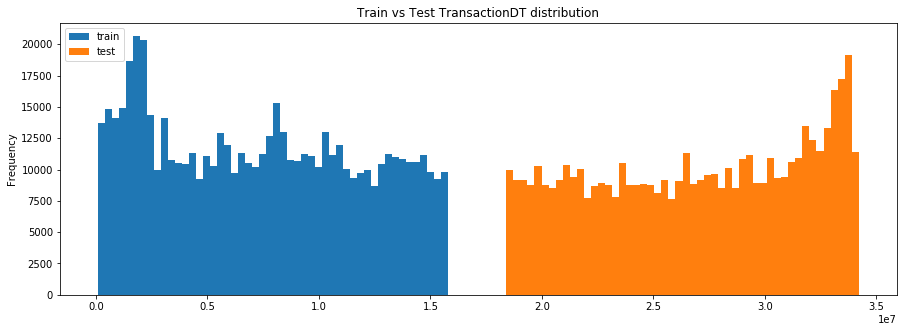

In [12]:
train['TransactionDT'].plot(kind='hist',
                                        figsize=(15, 5),
                                        label='train',
                                        bins=50,
                                        title='Train vs Test TransactionDT distribution')
test['TransactionDT'].plot(kind='hist',
                                       label='test',
                                       bins=50)
plt.legend()
plt.show()

### Explore some of the columns

In [13]:
col = 'id_07' # id_01, id_03, id_07, P_emaildomain, card4, card6
val_count = train[col].value_counts(normalize = True)

print(f'Length of data {len(train[col])}')
print(f'Num null values: {train[col].isna().sum()}')
print(f'Num different values: {len(val_count)}\n')

with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
    print(val_count)

Length of data 590540
Num null values: 585385
Num different values: 84

 0.0     0.079340
 16.0    0.047527
 14.0    0.044229
 12.0    0.040349
 15.0    0.036081
 17.0    0.034918
 4.0     0.034530
 13.0    0.033948
 5.0     0.029874
 10.0    0.029486
 25.0    0.028710
 3.0     0.027352
 22.0    0.026770
 26.0    0.026382
 23.0    0.026188
 24.0    0.025800
 27.0    0.025218
 11.0    0.025218
 8.0     0.024636
 18.0    0.024442
 21.0    0.023666
 20.0    0.022890
 7.0     0.021726
 9.0     0.021339
 2.0     0.020563
 6.0     0.020563
 1.0     0.018817
 19.0    0.017459
 30.0    0.017265
 29.0    0.015325
 28.0    0.011833
-1.0     0.009893
 31.0    0.008147
-2.0     0.006402
-3.0     0.006402
 32.0    0.005626
-4.0     0.005626
 33.0    0.005432
-5.0     0.005432
-6.0     0.005238
-8.0     0.004268
 35.0    0.003880
 37.0    0.003880
 39.0    0.003492
 36.0    0.003492
 34.0    0.003298
 38.0    0.003104
-10.0    0.002910
-7.0     0.002716
 42.0    0.002328
 40.0    0.002134
-9.0     0

## Plot

In [14]:
 def ploting_cnt_amt(df, col, lim=2000):
    tmp = pd.crosstab(df[col], df['isFraud'], normalize='index') * 100
    tmp = tmp.reset_index()
    tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)
    
    plt.figure(figsize=(20,11))    
    plt.suptitle(f'{col} Distributions ', fontsize=24)
    
    plt.subplot(211)
    g = sns.countplot( x=col,  data=df, order=list(tmp[col].values))
    gt = g.twinx()
    gt = sns.pointplot(x=col, y='Fraud', data=tmp, order=list(tmp[col].values),
                       color='black', legend=False, )
    gt.set_ylim(0,tmp['Fraud'].max()*1.1)
    gt.set_ylabel("%Fraud Transactions", fontsize=16)
    g.set_title(f"Most Frequent {col} values and % Fraud Transactions", fontsize=20)
    g.set_xlabel(f"{col} Category Names", fontsize=16)
    g.set_ylabel("Count", fontsize=17)
    g.set_xticklabels(g.get_xticklabels(),rotation=45)
    sizes = []
    for p in g.patches:
        height = p.get_height()
        sizes.append(height)
        g.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(height/total*100),
                ha="center",fontsize=12) 
        
    g.set_ylim(0,max(sizes)*1.15)

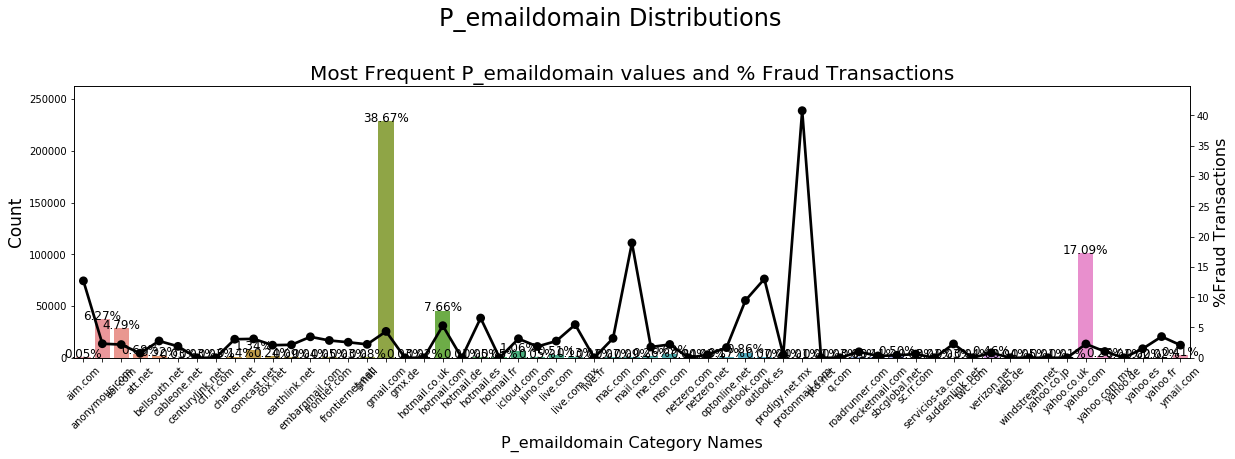

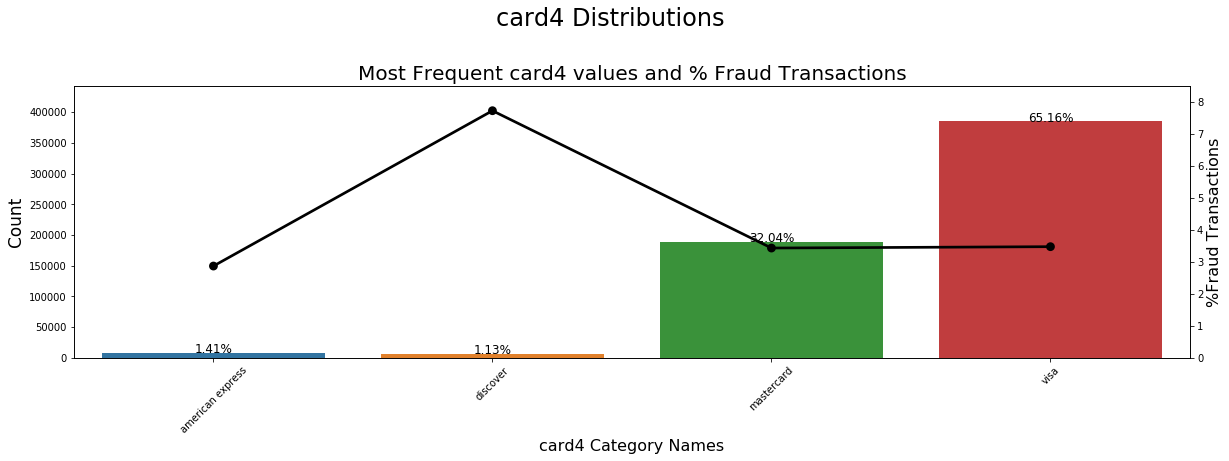

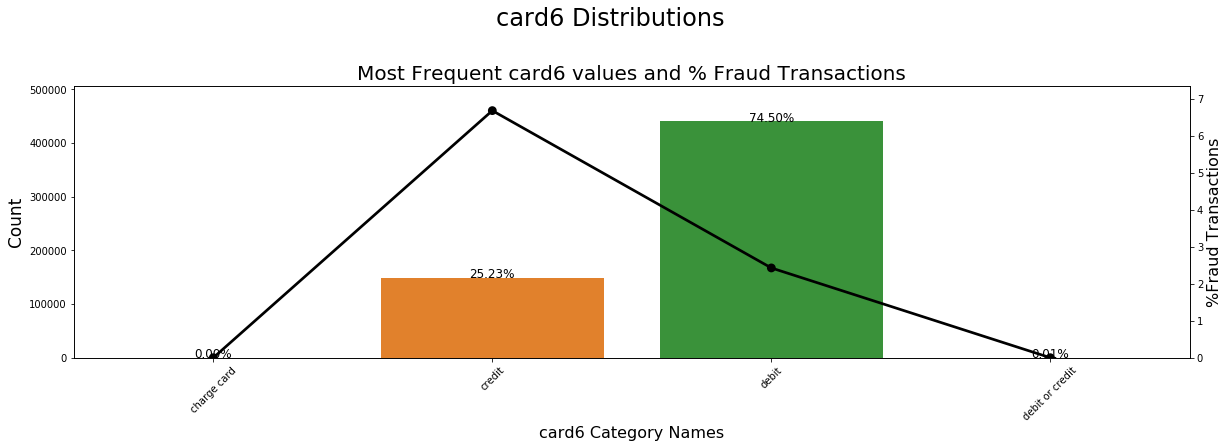

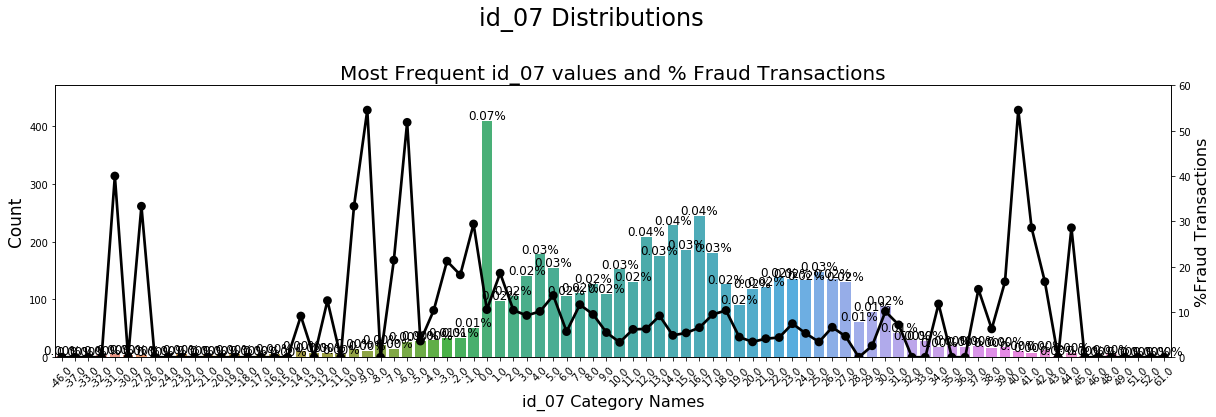

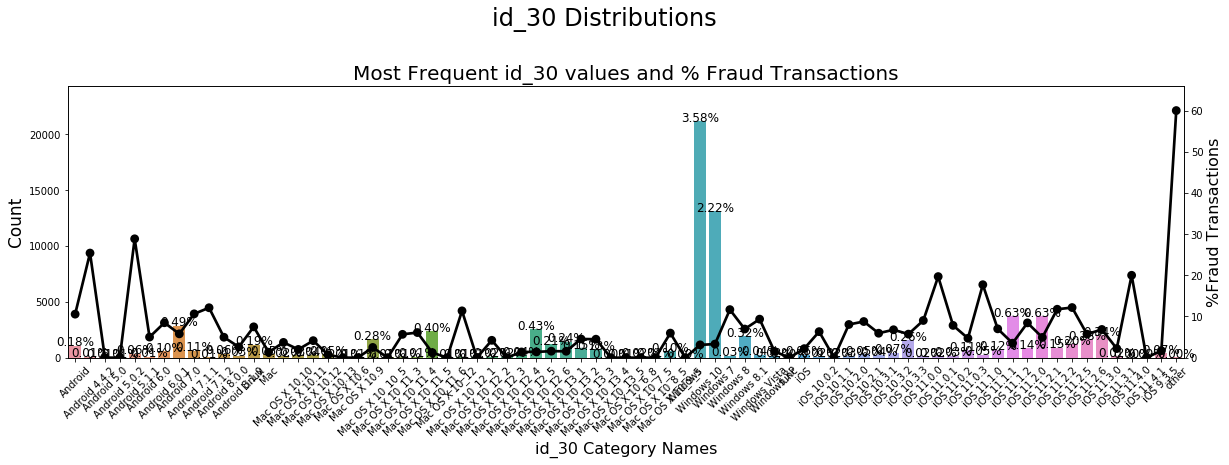

In [15]:
cols = ['P_emaildomain', 'card4', 'card6','id_07', 'id_30']
for col in cols:
    ploting_cnt_amt(train, col)

In [16]:
# #https://www.kaggle.com/kabure/extensive-eda-and-modeling-xgb-hyperopt
# cols = ['P_emaildomain', 'card4', 'card6','id_07', 'id_30']
# figs=[]
# for col in cols:
#     fig = px.histogram(train,x=col, width=800, height=300)
#     figs.append(fig)


In [17]:
# for fig in figs:
#     fig.show()

## Feature Engineering

In [18]:
# Standard normalization [-1,1] 
train['Trans_min_mean'] = train['TransactionAmt'] - train['TransactionAmt'].mean()
train['Trans_min_std'] = train['Trans_min_mean'] / train['TransactionAmt'].std()
test['Trans_min_mean'] = test['TransactionAmt'] - test['TransactionAmt'].mean()
test['Trans_min_std'] = test['Trans_min_mean'] / test['TransactionAmt'].std()

In [19]:
train['TransactionAmt_to_mean_card1'] = train['TransactionAmt'] / train.groupby(['card1'])['TransactionAmt'].transform('mean')
train['TransactionAmt_to_mean_card4'] = train['TransactionAmt'] / train.groupby(['card4'])['TransactionAmt'].transform('mean')
train['TransactionAmt_to_std_card1'] = train['TransactionAmt'] / train.groupby(['card1'])['TransactionAmt'].transform('std')
train['TransactionAmt_to_std_card4'] = train['TransactionAmt'] / train.groupby(['card4'])['TransactionAmt'].transform('std')

test['TransactionAmt_to_mean_card1'] = test['TransactionAmt'] / test.groupby(['card1'])['TransactionAmt'].transform('mean')
test['TransactionAmt_to_mean_card4'] = test['TransactionAmt'] / test.groupby(['card4'])['TransactionAmt'].transform('mean')
test['TransactionAmt_to_std_card1'] = test['TransactionAmt'] / test.groupby(['card1'])['TransactionAmt'].transform('std')
test['TransactionAmt_to_std_card4'] = test['TransactionAmt'] / test.groupby(['card4'])['TransactionAmt'].transform('std')

In [20]:
train['P_emaildomain_split_1'] = train['P_emaildomain'].apply(lambda x: str(x).split(".")[0] if len(str(x).split(".")) > 0 else '')
train['P_emaildomain_split_2'] = train['P_emaildomain'].apply(lambda x: str(x).split(".")[1] if len(str(x).split(".")) > 1 else x)
train['P_emaildomain_split_3'] = train['P_emaildomain'].apply(lambda x: str(x).split(".")[2] if len(str(x).split(".")) > 2 else '')

test['P_emaildomain_split_1'] = test['P_emaildomain'].apply(lambda x: str(x).split(".")[0] if len(str(x).split(".")) > 0 else '')
test['P_emaildomain_split_2'] = test['P_emaildomain'].apply(lambda x: str(x).split(".")[1] if len(str(x).split(".")) > 1 else x)
test['P_emaildomain_split_3'] = test['P_emaildomain'].apply(lambda x: str(x).split(".")[2] if len(str(x).split(".")) > 2 else '')

train['R_emaildomain_split_1'] = train['R_emaildomain'].apply(lambda x: str(x).split(".")[0] if len(str(x).split(".")) > 0 else '')
train['R_emaildomain_split_2'] = train['R_emaildomain'].apply(lambda x: str(x).split(".")[1] if len(str(x).split(".")) > 1 else x)
train['R_emaildomain_split_3'] = train['R_emaildomain'].apply(lambda x: str(x).split(".")[2] if len(str(x).split(".")) > 2 else '')

test['R_emaildomain_split_1'] = test['R_emaildomain'].apply(lambda x: str(x).split(".")[0] if len(str(x).split(".")) > 0 else '')
test['R_emaildomain_split_2'] = test['R_emaildomain'].apply(lambda x: str(x).split(".")[1] if len(str(x).split(".")) > 1 else x)
test['R_emaildomain_split_3'] = test['R_emaildomain'].apply(lambda x: str(x).split(".")[2] if len(str(x).split(".")) > 2 else '')

#Drop emaildomains columns
train = train.drop(["R_emaildomain", "P_emaildomain"], axis=1)
test = test.drop(["R_emaildomain", "P_emaildomain"], axis=1)

In [21]:
def isfloat(value):
  try:
    float(value)
    return True
  except ValueError:
    return False

In [22]:
train['id_31_1'] = train['id_31'].apply(lambda x: ' '.join([str(y) for y in str(x).split(' ') if not isfloat(y)]))
test['id_31_1'] = test['id_31'].apply(lambda x: ' '.join([str(y) for y in str(x).split(' ') if not isfloat(y)]))

train['id_31_2'] = train['id_31'].apply(lambda x: ' '.join([str(y) for y in str(x).split(' ') if isfloat(y)]))
test['id_31_2'] = test['id_31'].apply(lambda x: ' '.join([str(y) for y in str(x).split(' ') if isfloat(y)]))

#Drop id_31 columns
train = train.drop(["id_31"], axis=1)
test = test.drop(["id_31"], axis=1)

In [23]:
def make_day_feature(df, offset=0, tname='TransactionDT'):
    """
    Creates a day of the week feature, encoded as 0-6. 
    
    Parameters:
    -----------
    df : pd.DataFrame
        df to manipulate.
    offset : float (default=0)
        offset (in days) to shift the start/end of a day.
    tname : str
        Name of the time column in df.
    """
    # found a good offset is 0.58
    days = df[tname] / (3600*24)        
    encoded_days = np.floor(days-1+offset) % 7
    return encoded_days

def make_hour_feature(df, tname='TransactionDT'):
    """
    Creates an hour of the day feature, encoded as 0-23. 
    
    Parameters:
    -----------
    df : pd.DataFrame
        df to manipulate.
    tname : str
        Name of the time column in df.
    """
    hours = df[tname] / (3600)        
    encoded_hours = np.floor(hours) % 24
    return encoded_hours

train["Transaction_Day"] = make_day_feature(train)
train["Transaction_Hour"] = make_hour_feature(train)

test["Transaction_Day"] = make_day_feature(test)
test["Transaction_Hour"] = make_hour_feature(test)

In [24]:
#def change_value_id_33(x) :
#    if x in :
#        return x
#    else :
#        return 'etc'

#train["OS"] = 

## Data Prep

In [25]:
# Remove columns with too high null value count
high_null_count = [col for col in train.columns if train[col].isnull().sum() / train.shape[0] > 0.9]
high_null_cols_test = [col for col in test.columns if test[col].isnull().sum() / test.shape[0] > 0.9]

In [26]:
# Remove columns that mostly contains one value >90%. 
big_top_value_cols = [col for col in train.columns if train[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]
big_top_value_cols_test = [col for col in test.columns if test[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]

In [27]:
cols_to_drop = list(set(high_null_count + high_null_cols_test + big_top_value_cols + big_top_value_cols_test))
if 'isFraud' in cols_to_drop: cols_to_drop.remove('isFraud')
len(cols_to_drop)

84

In [28]:
train = train.drop(cols_to_drop, axis=1)
test = test.drop(cols_to_drop, axis=1)

In [29]:
#cols = pd.concat([train, test]).select_dtypes(include = ['object']).columns

### Encode the categorical columns

In [30]:
def clean_inf_nan(df):
    return df.replace([np.inf, -np.inf], np.nan)   

# Cleaning infinite values to NaN
train = clean_inf_nan(train)
test = clean_inf_nan(test)

In [31]:
cat_cols = ['id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_19', 'id_20', 'id_28', 'id_29',
            'id_30', 'id_31_1', 'id_31_2', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo', 'ProductCD', 'card4', 'card6', 'M4',
            'R_emaildomain_split_1', 'R_emaildomain_split_2', 'card1', 'card2', 'card3',  'card5', 'addr1', 'addr2', 'M1', 'M2', 'M3', 'M5', 'M6', 'M7', 'M8', 'M9',
            'P_emaildomain_split_1', 'P_emaildomain_split_2']


for col in cat_cols:
    if col in train.columns:
        le = LabelEncoder()
        le.fit(list(train[col].astype(str).values) + list(test[col].astype(str).values))
        train[col] = le.transform(list(train[col].astype(str).values))
        test[col] = le.transform(list(test[col].astype(str).values))   

        
#cat_cols = ['R_emaildomain_split_1', 'R_emaildomain_split_2',
#            'P_emaildomain_split_1', 'P_emaildomain_split_2']

#num_cols = [c for c in train.columns if c not in cat_cols]

#def one_hot(X, X_test):
#    df = pd.concat([X, X_test])
#    df_num = df[num_cols]
#    df_cat = df[cat_cols]
#    df_cat_one_hot = pd.get_dummies(df_cat)
#    df = pd.concat([df_num, df_cat_one_hot], axis=1)
#    return df[:len(X)], df[len(X):]

#train, test = one_hot(train, test)

In [32]:
len(train.columns)

363

## Make train and test sets 

In [33]:
X = train.sort_values('TransactionDT').drop(['isFraud', 'TransactionDT', 'TransactionID'], axis=1)
y = train.sort_values('TransactionDT')['isFraud']
#X_test = test.sort_values('TransactionDT').drop(['TransactionDT', 'TransactionID'], axis=1)
X_test = test.drop(['TransactionDT', 'TransactionID'], axis=1)
del train, test
# test = test[["TransactionDT", 'TransactionID']]

### Remove infinite values

In [34]:
gc.collect()

74106

## Train

In [35]:
n_fold = 5
folds = TimeSeriesSplit(n_splits=n_fold)
folds = KFold(n_splits=n_fold)

In [36]:
#Train / validation split
train_percentage = 0.8
train_count = X.shape[0]
X_train = X.iloc[0:int(train_count*train_percentage), :]
X_val = X.iloc[int(train_count*train_percentage):, :]
y_train = y.iloc[0:int(train_count*train_percentage)]
y_val = y.iloc[int(train_count*train_percentage):]

In [37]:
#!rm -r /opt/conda/lib/python3.6/site-packages/lightgbm
#!git clone --recursive https://github.com/Microsoft/LightGBM

In [38]:
#!apt-get install -y -qq libboost-all-dev

In [39]:
#%%bash
#cd LightGBM
#rm -r build
#mkdir build
#cd build
#cmake -DUSE_GPU=1 -DOpenCL_LIBRARY=/usr/local/cuda/lib64/libOpenCL.so -DOpenCL_INCLUDE_DIR=/usr/local/cuda/include/ ..
#make -j$(nproc)

In [40]:
#!cd LightGBM/python-package/;python3 setup.py install --precompile

In [41]:
#!mkdir -p /etc/OpenCL/vendors && echo "libnvidia-opencl.so.1" > /etc/OpenCL/vendors/nvidia.icd
#!rm -r LightGBM

In [42]:
import lightgbm as lgb
print("LightGBM version:", lgb.__version__)

LightGBM version: 2.2.3


In [43]:
#params = {'num_leaves': 500,
#          'min_child_weight': 0.03,
#          'feature_fraction': 0.35,
#          'bagging_fraction': 0.35,
#          'min_data_in_leaf': 100,
#          'objective': 'binary',
#          'max_depth': 15,
#          'learning_rate': 0.015,
#          "boosting_type": "gbdt",
#          "bagging_seed": 10,
#          "metric": 'auc',
#          "verbosity": -1,
#          'reg_alpha': 0.2,
#          'reg_lambda': 0.6,
#          'random_state': 50#,
          #'device': 'gpu',
          #'gpu_platform_id': 0,
          #'gpu_device_id': 0
#         }


#dtrain = lgb.Dataset(X_train, label=y_train)
#dvalid = lgb.Dataset(X_val, label=y_val)

#model = lgb.train(params, dtrain, 10000, valid_sets = [dtrain, dvalid], verbose_eval=100, early_stopping_rounds=200)
    

#prediction_LGB = model.predict(X_test)
#prediction_val_LGB = model.predict(X_val)

In [44]:
#param = {'booster' : 'gbtree',
#         'max_depth' : 13,
#         'nthread' : -1,
#         'num_class' : 1,
#         'objective' : 'binary:logistic',
#         'silent' : 1,
#         'eval_metric' : 'auc',
#         'eta' : 0.025,
#         'tree_method' : 'gpu_hist',
#         'min_child_weight' : 0,
#         'colsample_bytree' : 0.8,
#         'colsample_bylevel' : 0.8,
#         'seed' : 2019}



    
#print("Train Shape :", X_train.shape,
#      "Validation Shape :", X_val.shape,
#      "Test Shape :", X_test.shape)
    
#dtrn = xgb.DMatrix(X_train, label=y_train, feature_names = X.columns)
#dval = xgb.DMatrix(X_val, label = y_val, feature_names = X.columns)
#dtst = xgb.DMatrix(X_test, feature_names = X.columns)
    
#model = xgb.train(param, dtrn, num_boost_round=10000, evals = [(dtrn, 'train'), (dval, 'eval')],
#                 early_stopping_rounds = 200, verbose_eval=200)
                 
#prediction_XGB = model.predict(dtst)

#prediction_val_XGB = model.predict(xgb.DMatrix(X_val, feature_names = X.columns))

Fold 1 started at Tue Sep 24 08:48:43 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's auc: 0.994917	training's auc: 0.994917	valid_1's auc: 0.91865	valid_1's auc: 0.91865
Early stopping, best iteration is:
[528]	training's auc: 0.99537	training's auc: 0.99537	valid_1's auc: 0.918941	valid_1's auc: 0.918941
Fold 2 started at Tue Sep 24 09:00:35 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's auc: 0.995189	training's auc: 0.995189	valid_1's auc: 0.93191	valid_1's auc: 0.93191
Early stopping, best iteration is:
[714]	training's auc: 0.998213	training's auc: 0.998213	valid_1's auc: 0.932934	valid_1's auc: 0.932934
Fold 3 started at Tue Sep 24 09:14:40 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's auc: 0.995217	training's auc: 0.995217	valid_1's auc: 0.926229	valid_1's auc: 0.926229
Early stopping, best iteration is:
[361]	training's auc: 0.99126	training's auc: 0.99126	valid_1's

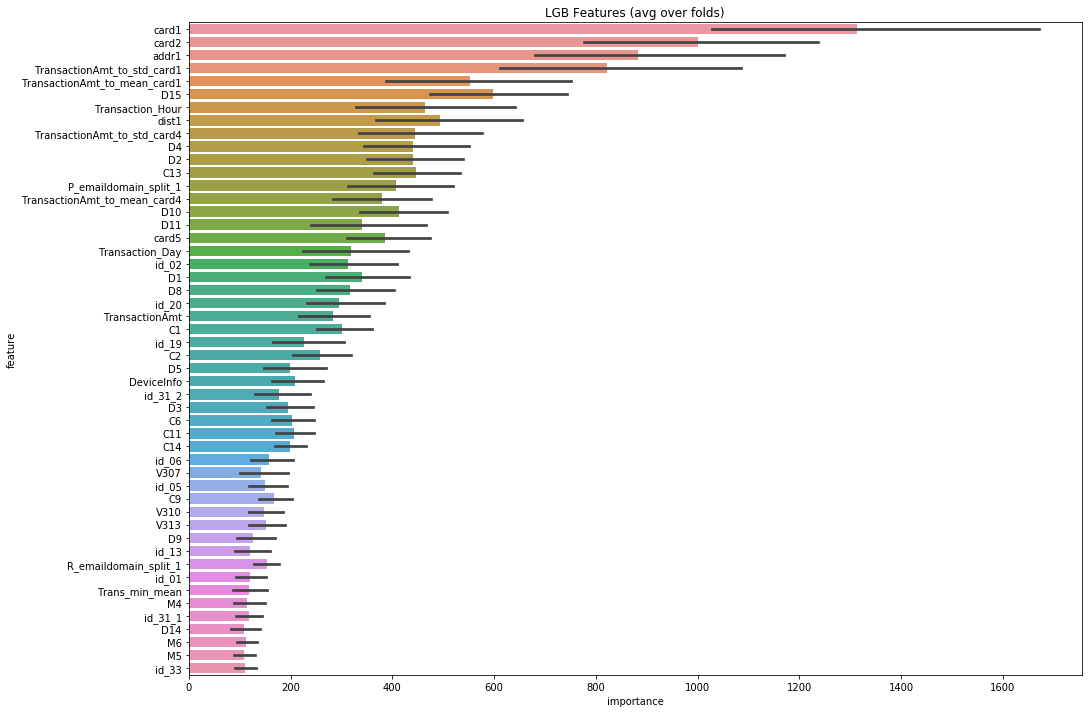

In [45]:
params = {'num_leaves': 256,
          'min_child_samples': 79,
          'objective': 'binary',
          'max_depth': 13, # Depth of the tree
          'learning_rate': 0.03,
          "boosting_type": "gbdt", # traditional Gradient Boosting Decision Tree
          "subsample_freq": 3,
          "subsample": 0.9,
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3,
          'reg_lambda': 0.3,
          'colsample_bytree': 0.9,
          #'categorical_feature': cat_cols
         }
result_dict_lgb = train_model_classification(X=X, X_test=X_test, y=y, params=params, folds=folds, model_type='lgb', eval_metric='auc', plot_feature_importance=True,
                                                      verbose=500, early_stopping_rounds=200, n_estimators=5000, averaging='usual', n_jobs=-1)

In [46]:
def get_combined_pred(i, xgb, lgb):
    i_inv = 1-i;
    return (i * xgb) + (i_inv * lgb)

In [47]:
#best_i = 0
#best_auc = 0
#for i in [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]:
#    val_pred = get_combined_pred(i, prediction_val_XGB, prediction_val_LGB)
#    roc_auc_score = metrics.roc_auc_score(y_val,val_pred)
#    if(roc_auc_score > best_auc):
#        best_auc = roc_auc_score
#        best_i = i

In [48]:
#sample_submission['isFraud'] = get_combined_pred(best_i, prediction_XGB, prediction_LGB)
sample_submission['isFraud'] = result_dict_lgb['prediction']
sample_submission.to_csv('submission_combined_2.csv', index=False)

In [49]:
print(len(sample_submission))
sample_submission.head()

506691


,TransactionID,isFraud
0,3663549,0.002003
1,3663550,0.001829
2,3663551,0.003612
3,3663552,0.002196
4,3663553,0.001976


In [50]:
#best_auc